In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import json

In [2]:
# Image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/train'
val_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/validation'
test_path = 'C:/Users/AJ/OneDrive/Desktop/school/Neural Networks and Deep Learning/Weeds and Crops Classification/dataset_2_split/test'

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data = train_datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
val_data = val_test_datagen.flow_from_directory(val_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
test_data = val_test_datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

Found 6407 images belonging to 12 classes.
Found 1368 images belonging to 12 classes.
Found 1369 images belonging to 12 classes.


In [5]:
# MobileNet Model Definition
def build_mobilenet_model(input_shape=(128, 128, 3), num_classes=12):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = build_mobilenet_model()

In [6]:
history_mobilenet = mobilenet_model.fit(train_data, validation_data=val_data, epochs=50)

Epoch 1/50
201/201 [==============================] - 86s 338ms/step - loss: 3.5392 - accuracy: 0.1019 - val_loss: 2.2349 - val_accuracy: 0.2420
Epoch 2/50
201/201 [==============================] - 45s 222ms/step - loss: 2.9278 - accuracy: 0.1871 - val_loss: 1.8580 - val_accuracy: 0.3787
Epoch 3/50
201/201 [==============================] - 48s 238ms/step - loss: 2.5975 - accuracy: 0.2407 - val_loss: 1.6340 - val_accuracy: 0.4532
Epoch 4/50
201/201 [==============================] - 51s 253ms/step - loss: 2.3716 - accuracy: 0.2856 - val_loss: 1.4588 - val_accuracy: 0.5000
Epoch 5/50
201/201 [==============================] - 50s 251ms/step - loss: 2.1950 - accuracy: 0.3239 - val_loss: 1.3397 - val_accuracy: 0.5490
Epoch 6/50
201/201 [==============================] - 48s 240ms/step - loss: 2.0634 - accuracy: 0.3562 - val_loss: 1.2500 - val_accuracy: 0.5731
Epoch 7/50
201/201 [==============================] - 42s 209ms/step - loss: 1.9158 - accuracy: 0.3957 - val_loss: 1.1818 - val_ac

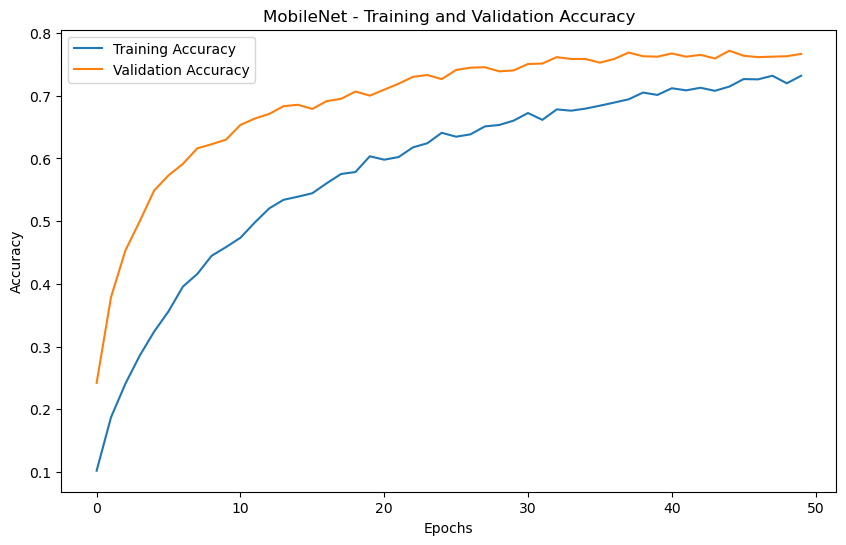

In [7]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MobileNet - Training and Validation Accuracy')
plt.show()

In [8]:
# Evaluate on Test Data
test_loss, test_accuracy = mobilenet_model.evaluate(test_data)
print(f'ResNet50 Test Accuracy: {test_accuracy * 100:.2f}%')

43/43 [==============================] - 10s 214ms/step - loss: 0.6025 - accuracy: 0.7706
ResNet50 Test Accuracy: 77.06%


43/43 [==============================] - 9s 179ms/step


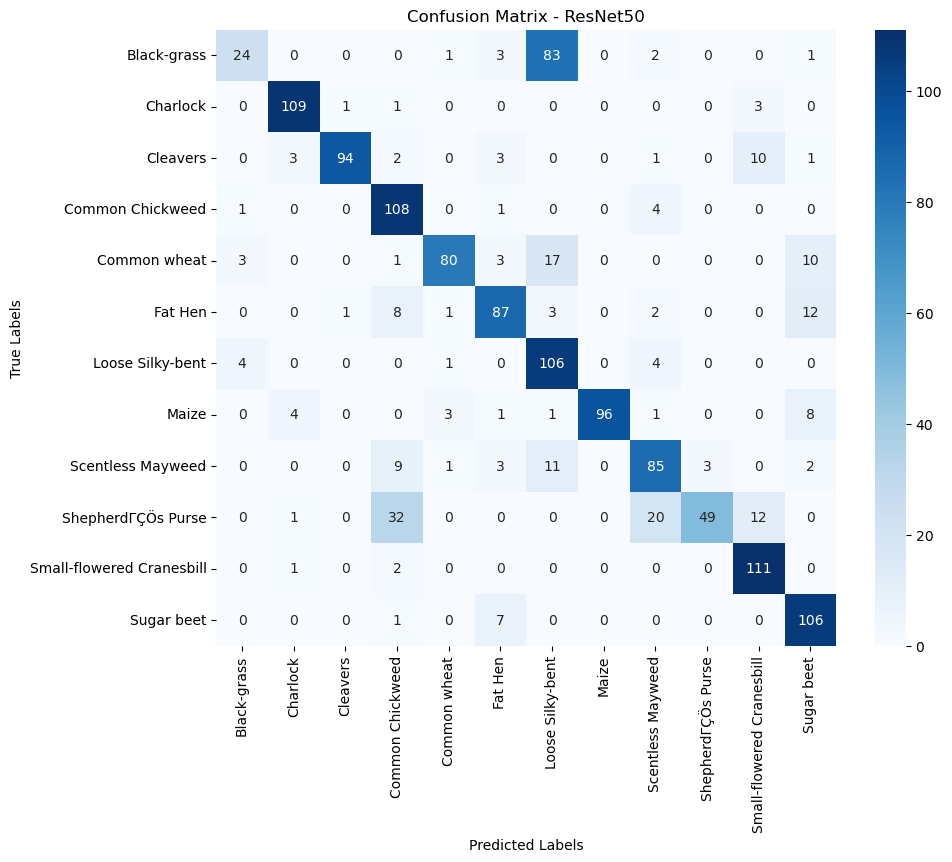

In [9]:
# Confusion Matrix and Classification Report
predictions = np.argmax(mobilenet_model.predict(test_data), axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Plot Confusion Matrix
cm = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - ResNet50')
plt.show()

In [10]:
print("Classification Report for ResNet50")
print(classification_report(true_classes, predictions, target_names=class_labels))

Classification Report for ResNet50
                           precision    recall  f1-score   support

              Black-grass       0.75      0.21      0.33       114
                 Charlock       0.92      0.96      0.94       114
                 Cleavers       0.98      0.82      0.90       114
         Common Chickweed       0.66      0.95      0.78       114
             Common wheat       0.92      0.70      0.80       114
                  Fat Hen       0.81      0.76      0.78       114
         Loose Silky-bent       0.48      0.92      0.63       115
                    Maize       1.00      0.84      0.91       114
        Scentless Mayweed       0.71      0.75      0.73       114
       ShepherdΓÇÖs Purse       0.94      0.43      0.59       114
Small-flowered Cranesbill       0.82      0.97      0.89       114
               Sugar beet       0.76      0.93      0.83       114

                 accuracy                           0.77      1369
                macro avg

In [11]:
mobilenet_model.save("MobileNet_model.h5")
print("ResNet50 model saved as 'resnet50_model.h5'")

ResNet50 model saved as 'resnet50_model.h5'


In [12]:
# Save Metadata
metadata = {
    "train_accuracy": history_mobilenet.history['accuracy'][-1],  # Last epoch's training accuracy
    "val_accuracy": history_mobilenet.history['val_accuracy'][-1],  # Last epoch's validation accuracy
    "test_accuracy": test_accuracy,  # Test accuracy
    "num_classes": len(train_data.class_indices),  # Number of classes
    "class_indices": train_data.class_indices
}

# Save metadata as a JSON file
with open("MobileNet_metadata.json", "w") as metadata_file:
    json.dump(metadata, metadata_file, indent=4)

print("MobileNet metadata saved as 'MobileNet_metadata.json'")

MobileNet metadata saved as 'MobileNet_metadata.json'
